In [1]:
%matplotlib inline

## Search start learning rate for minimal example

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import random

import ssd.transforms.transforms as tr
from torch.utils.data import Dataset
from ssd.utils.misc import count_files, collect_filenames

In [2]:
print(torch.__version__)

0.4.1.post2


In [3]:
class MinBrainIOI(Dataset):
    """Frames from intrinsic optical imaging data of the human cortex"""

    def __init__(self, csv_file, root_dir, border=0, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the frames per patient.
            border (int): additional border in pixels to expand bounding box
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable): Transform bounding boxes from general representation to specific for cnn

        """
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.classes = ["BACKGROUND", "stimulation"]
        self.border = border  # pixel
        self.files, self.class_labels = self.create_file_list()
        self.bins = self.create_bins()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return int(len(self.class_labels) / 2)

    def __getitem__(self, idx):
        """
        2 images will be combined per sample

        Return: combined sample, one bbox as list and one label as list
        """
        loc = idx * 2
        image1 = cv2.imread(self.files[loc], cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        image2 = cv2.imread(self.files[loc + 1], cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        sample = np.dstack((image1, image2))
        height, width, channel = sample.shape
        bbox = [0, 0, width, height] # default box is whole image
        if self.class_labels[loc] == 1:
            pos = np.digitize(loc, self.bins) - 1  # find out which annotation belongs to data
            tips = self.annotations.iloc[pos, 3:].values.reshape(2,2)  # 2 electrode tips for each picture ([posx1, posy1], [posx2, posy2])
            bbox = [self._min_with_border(tips[0][0], tips[1][0]), self._min_with_border(tips[0][1], tips[1][1]),
                    self._max_with_border(tips[0][0], tips[1][0], width),
                    self._max_with_border(tips[0][1], tips[1][1], height)]

        if self.transform:
            sample, bbox = self.transform(sample, bbox)
        else:
            transform = ToTensor()
            sample, bbox = transform(sample, bbox)

        # create bbox and labels as list, if we should have multiple labels per image
        boxes = bbox.unsqueeze(0)
        labels = torch.LongTensor([self.class_labels[loc]])
        if self.target_transform:
            boxes, labels = self.target_transform(boxes, labels)

        return sample, boxes, labels

    def create_bins(self):
        sub_folders = ["stimulation"]
        bins = [0]
        for i in range(0, len(self.annotations)):
            parent = os.path.join(self.root_dir, self.annotations.iloc[i, 0])
            sum_bin = 0
            for child in sub_folders:
                count = count_files(os.path.join(parent, child), '.tif')
                if count % 2 != 0:
                    count -= 1

                sum_bin += count

            bins.append(bins[i] + sum_bin)

        return bins

    def create_file_list(self):
        sub_folders = ["stimulation"]
        file_list = []
        class_labels = []
        for i in range(0, len(self.annotations)):
            parent = os.path.join(self.root_dir, self.annotations.iloc[i, 0])
            for child in sub_folders:
                files = collect_filenames(os.path.join(parent, child), '.tif')
                if len(files) % 2 != 0:
                    files = files[:-1]

                file_list += files[:2] # only store 1 image per sample
                cur_class = 1
                class_labels += [cur_class for _ in range(len(files[:2]))]

        return file_list, class_labels

    def _min_with_border(self, x, y):
        tmp_min = min(x, y)
        if tmp_min >= self.border:
            tmp_min -= self.border

        return tmp_min

    def _max_with_border(self, x, y, limit):
        tmp_max = max(x, y) + self.border
        if tmp_max > limit:
            tmp_max = limit

        return tmp_max



In [4]:
from ssd.model.ssd import MatchPrior, SSD
from ssd.config import mobilenetv1_ssd_config
from ssd.utils.misc import str2bool, Timer, freeze_net_layers

from ssd.transforms.preprocessing import TrainAugmentation, TestTransform

from ssd.model.multibox_loss import MultiboxLoss

from torch.utils.data import DataLoader

In [5]:
import itertools

In [6]:
def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        num += 1
        
    return running_loss / num, running_regression_loss / num, running_classification_loss / num  

In [7]:
def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num

In [8]:
def find_lr(train_loader, test_loader, model, start_lr, max_lr, num_epochs, opt):
#     import pdb; pdb.set_trace()

    n = 16 # number of iterations
    q = (max_lr / start_lr)**(1./n)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=q) #torch.optim.lr_scheduler.ExponentialLR(opt, gamma)
    losses = []
    lrs = []
    best_loss = 10**10
    for epoch in range(0, num_epochs):
        print("Epoch " + str(epoch))
        sched.step()
        loss, regression_loss, classification_loss = train(train_loader, net, criterion, optimizer,
              device=DEVICE, debug_steps=10, epoch=epoch)
        
        print("regression_loss: " + str(regression_loss) + " classification_loss: " + str(classification_loss))
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        print("val_loss: " + str(val_regression_loss) + " val_classification_loss: " + str(val_classification_loss))
        
        lrs.append(sched.get_lr()[0])
        losses.append(loss)
        
        print("lr: " + str(sched.get_lr()[0]))
        
        if loss < best_loss:
            best_loss = loss
        
        if loss > 4*best_loss:
            break
            
    return lrs, losses
        


In [13]:
batch_size = 1
num_workers = 2

dataset="/home/maggie/Dokumente/Diplomarbeit/source_code/data/train"
validation_dataset="/home/maggie/Dokumente/Diplomarbeit/source_code/data/val"

DEVICE = "cuda" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = mobilenetv1_ssd_config

train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std, 0.7)
target_transform = MatchPrior(config.priors, config.center_variance,
                                  config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std,)

train_dataset = MinBrainIOI(os.path.join(dataset, 'stimulation.csv'), dataset, border=10,
                                    transform=train_transform, target_transform=target_transform)
print("Train dataset size: {}".format(len(train_dataset)))

train_loader = DataLoader(train_dataset, batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

val_dataset = MinBrainIOI(os.path.join(validation_dataset, 'stimulation.csv'), validation_dataset,
                                  transform=test_transform, target_transform=target_transform)
print("validation dataset size: {}".format(len(val_dataset)))
val_loader = DataLoader(val_dataset, batch_size,
                            num_workers=num_workers,
                            shuffle=False)
num_classes = len(train_dataset.classes)
net = SSD(num_classes, config=config)
net.to(DEVICE)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                             center_variance=0.1, size_variance=0.2, device=DEVICE)

start_lr =  0.00001 #0.00015625 #0.01
max_lr = 10

params = [
            {'params': net.base_net.parameters(), 'lr': start_lr},
            {'params': itertools.chain(
                net.source_layer_add_ons.parameters(),
                net.extras.parameters()
            ), 'lr': start_lr},
            {'params': itertools.chain(
                net.regression_headers.parameters(),
                net.classification_headers.parameters()
            )}
        ]

optimizer = torch.optim.SGD(params, lr=start_lr, momentum=0.9, weight_decay=5e-4)

Train dataset size: 16
validation dataset size: 4


In [14]:
import pickle
import matplotlib.pyplot as plt

In [15]:
num_epochs = 120

Epoch 0


/home/maggie/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


regression_loss: 27.008027374744415 classification_loss: 4.7908021211624146
val_loss: 10.915264129638672 val_classification_loss: 2.901122570037842
lr: 1e-05
Epoch 1
regression_loss: 92.10428434610367 classification_loss: 4.0379407703876495
val_loss: 11.83589220046997 val_classification_loss: 2.9674611687660217
lr: 2.3713737056616554e-05
Epoch 2
regression_loss: 42.28953951597214 classification_loss: 3.5705654621124268
val_loss: 11.343942642211914 val_classification_loss: 3.1187018156051636
lr: 5.623413251903491e-05
Epoch 3
regression_loss: 64.9726523719728 classification_loss: 3.3441189378499985
val_loss: 8.0523020029068 val_classification_loss: 3.251709759235382
lr: 0.00013335214321633237
Epoch 4
regression_loss: 37.732464265078306 classification_loss: 3.504834771156311
val_loss: 18.53620481491089 val_classification_loss: 21.66500687599182
lr: 0.00031622776601683783
Epoch 5
regression_loss: 66.59672884829342 classification_loss: 5.280812382698059
val_loss: 2780.1778717041016 val_clas

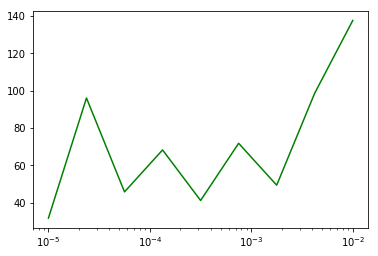

In [16]:
lrs, losses = find_lr(train_loader, val_loader, net, start_lr, max_lr, num_epochs, optimizer)
file_name = str(start_lr) + "_" + str(max_lr) + "_losses.txt"
with open(file_name, "wb") as fp:
    pickle.dump([lrs, losses], fp)
    
#plt.plot(lrs, losses, 'b-')
plt.semilogx(lrs, losses, 'g-')

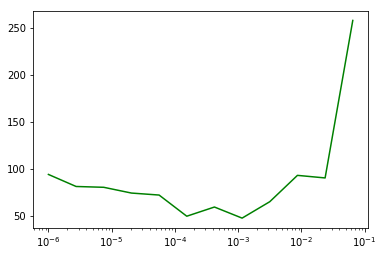

In [25]:
plt.semilogx(lrs, losses, 'g-')